In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import concatenate, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Activation, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# seed
import os
seed = 123
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.set_random_seed(seed)

In [2]:
train = np.load('data/train.npy', allow_pickle = 'True')
test = np.load('data/test.npy', allow_pickle = 'True')

In [3]:
train_image = train[:,2:].reshape(-1,28,28).astype(np.int)
train_digit = train[:,0]
train_letter = train[:,1]
train_del_noise = np.where(train_image>=150, train_image, 0)

test_image = test[:,1:].reshape(-1,28,28).astype(np.int)

In [4]:
def class_pca(data, num):
    lst = []
    for idx in range(len(data)):
        if train_digit[idx] == num:
            lst.append(train_del_noise[idx])
    lst = np.array(lst)
    
    pca = PCA(n_components=2)
    x = lst.reshape(lst.shape[0],-1).copy()
    w = pca.fit_transform(x)
    f = pca.components_.reshape(1,-1)
    return f

In [5]:
label_0 = class_pca(train_image, 0)
label_1 = class_pca(train_image, 1)
label_2 = class_pca(train_image, 2)
label_3 = class_pca(train_image, 3)
label_4 = class_pca(train_image, 4)
label_5 = class_pca(train_image, 5)
label_6 = class_pca(train_image, 6)
label_7 = class_pca(train_image, 7)
label_8 = class_pca(train_image, 8)
label_9 = class_pca(train_image, 9)

In [6]:
mid_label = []
for idx in range(len(train_digit)):
    if train_digit[idx] == 0:
        mid_label.append(label_0)
    elif train_digit[idx] == 1:
        mid_label.append(label_1)
    elif train_digit[idx] == 2:
        mid_label.append(label_2)
    elif train_digit[idx] == 3:
        mid_label.append(label_3)
    elif train_digit[idx] == 4:
        mid_label.append(label_4)
    elif train_digit[idx] == 5:
        mid_label.append(label_5)
    elif train_digit[idx] == 6:
        mid_label.append(label_6)
    elif train_digit[idx] == 7:
        mid_label.append(label_7)
    elif train_digit[idx] == 8:
        mid_label.append(label_8)
    else:
        mid_label.append(label_9)
mid_label = np.array(mid_label)
m = mid_label.reshape(-1,mid_label.shape[2])

In [7]:
scaler = MinMaxScaler()
scaler.fit(m)
m_scaled = scaler.transform(m)

In [8]:
m_scaled.shape

(2048, 1568)

In [9]:
x = train[:,2:]
x = np.reshape(x, (-1, 28, 28, 1))
x = x/255

y = train[:,0]
y = np.reshape(y, (-1, 1))
en = OneHotEncoder()
y = en.fit_transform(y).toarray()

print(x.shape)
print(y.shape)

(2048, 28, 28, 1)
(2048, 10)


In [10]:
valid_size = 48
valid_x = x[-valid_size:]
x = x[:-valid_size]

valid_y = y[-valid_size:]
y = y[:-valid_size]

valid_m = m_scaled[-valid_size:]
m = m_scaled[:-valid_size]

print(x.shape)
print(valid_x.shape)
print(y.shape)
print(valid_y.shape)
print(m.shape)
print(valid_m.shape)

(2000, 28, 28, 1)
(48, 28, 28, 1)
(2000, 10)
(48, 10)
(2000, 1568)
(48, 1568)


In [11]:
image_generator = ImageDataGenerator(width_shift_range=0.1,
                                     height_shift_range=0.1, 
                                     zoom_range=[0.8,1.2],
                                     shear_range=10)

In [12]:
x_total = x.copy()
def augment(x):
    aug_list = []
    for i in range(x.shape[0]):
        num_aug = 0
        tmp = x[i]
        tmp = tmp.reshape((1,) + tmp.shape)
        for x_aug in image_generator.flow(tmp, batch_size = 1) :
            if num_aug >= 1:
                break
            aug_list.append(x_aug[0])
            num_aug += 1
    aug_list = np.array(aug_list)
    return aug_list

n = 2
for i in range(n):
    arr = augment(x)
    x_total = np.concatenate((x_total, arr), axis=0)
    if i > n:
        break

print(x_total.shape)

(6000, 28, 28, 1)


In [13]:
y_total = y.copy()
for i in range(n):
    arr = y.copy()
    y_total = np.concatenate((y_total, arr), axis=0)
    
m_total = m.copy()
for i in range(n):
    arr = m.copy()
    m_total = np.concatenate((m_total, arr), axis=0)

print(y_total.shape)
print(m_total.shape)

(6000, 10)
(6000, 1568)


In [14]:
x_train, x_val, y_train, y_val = train_test_split(x_total, y_total, test_size=0.2, 
                                                  shuffle=True)#, stratify=y_total)

m_train = m_total[:x_train.shape[0],:]
m_val = m_total[x_train.shape[0]:,:]

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)
print(m_train.shape)
print(m_val.shape)

(4800, 28, 28, 1)
(1200, 28, 28, 1)
(4800, 10)
(1200, 10)
(4800, 1568)
(1200, 1568)


In [25]:
def CNN(model_input, classes):
    x = Conv2D(64, (3,3), activation='elu', padding='same')(model_input)
    x = Conv2D(64, (3,3), activation='elu', padding='same')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='elu', padding='same')(x)
    x = Conv2D(64, (3,3), activation='elu', padding='same')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D((2,2))(x)
    #x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    #x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    #x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(2000, activation='elu')(x)
    #x = Dropout(0.3)(x)
    #x = GlobalAveragePooling2D()(x)
    outputs = Dense(classes, activation='softmax')(x)
    
    model = Model(inputs = model_input, outputs = outputs)
    
    return model

In [26]:
layers_in_block = {'DenseNet-121':[6, 12, 24, 16],
                   'DenseNet-169':[6, 12, 32, 32],
                   'DenseNet-201':[6, 12, 48, 32],
                   'DenseNet-265':[6, 12, 64, 48],
                   'myDenseNet':[8, 12, 16, 32]}

base_growth_rate = 32

model_input = Input(shape=(28,28,1))
classes = 1568

#model = DenseNet(model_input, classes, 'DenseNet-121')
model = CNN(model_input, classes)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
dropout_3 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        36928     
__________

In [27]:
model.compile(optimizer = 'adam', metrics = ['mae'], loss = 'mse')
history = model.fit(x_train, m_train, validation_data=(x_val, m_val), 
                    batch_size=64, epochs=10, verbose=1)

Train on 4800 samples, validate on 1200 samples
Epoch 1/10
4800/4800 [==============================] - 4s 819us/step - loss: 0.2313 - mean_absolute_error: 0.3251 - val_loss: 0.2305 - val_mean_absolute_error: 0.3243
Epoch 2/10
4800/4800 [==============================] - 2s 510us/step - loss: 0.2313 - mean_absolute_error: 0.3250 - val_loss: 0.2305 - val_mean_absolute_error: 0.3243
Epoch 3/10
4800/4800 [==============================] - 2s 511us/step - loss: 0.2313 - mean_absolute_error: 0.3250 - val_loss: 0.2305 - val_mean_absolute_error: 0.3243
Epoch 4/10
4800/4800 [==============================] - 2s 517us/step - loss: 0.2313 - mean_absolute_error: 0.3250 - val_loss: 0.2305 - val_mean_absolute_error: 0.3243
Epoch 5/10
4800/4800 [==============================] - 2s 514us/step - loss: 0.2313 - mean_absolute_error: 0.3250 - val_loss: 0.2305 - val_mean_absolute_error: 0.3243
Epoch 6/10
4800/4800 [==============================] - 2s 508us/step - loss: 0.2313 - mean_absolute_error: 0.32

In [28]:
pred = model.predict(valid_x)

In [35]:
real_pred = scaler.inverse_transform(pred)
real_pred

array([[-3.1237258e-17, -1.1856914e-17, -1.5537834e-18, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-3.1237258e-17, -1.1856914e-17, -1.5537834e-18, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-3.1237258e-17, -1.1856914e-17, -1.5537834e-18, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [-3.1237258e-17, -1.1856914e-17, -1.5537834e-18, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-3.1237258e-17, -1.1856914e-17, -1.5537834e-18, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-3.1237258e-17, -1.1856914e-17, -1.5537834e-18, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

(-0.5, 27.5, 27.5, -0.5)

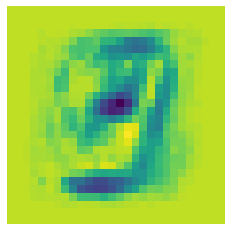

In [34]:
img = real_pred[10].reshape(-1,28,28)
img_1 = img[1]
plt.imshow(img_1)
plt.axis('off')